# Data Modeling and analysis of OpenSky and JHU COVID-19 datasets

## Project Scope
COVID-19 pandemic has been one of the most significant events to affect mankind in recent history. Its impact on human lives and economies has been quite devastating. This project tries to explore the progression of COVID-19 in regions across the world and its impact on the airline industry. Airline industry can be broadly seen as an indicator of global commerce activity. Conversely, flight data can also be used to find patterns of spread across the regions through virus vectors aboard international flights. However, this might require more granular information and is out of scope of this project.

We will be using a flight dataset that tracks aircraft using ADS-B equipment around the world. We can aggregate the flight data to calculate incoming and outgoing traffic from each airport. We can then aggregate the airport data to region or country level and compare with COVID-19 data.


### Datasets
1. OpenSky COVID-19 Dataset - We will be modeling and aggregating flight data from OpenSky flight dataset.

https://opensky-network.org/community/blog/item/6-opensky-covid-19-flight-dataset

2. John Hopkins University Enigma Timeseries - For COVID-19, we will be using John Hopkins University's Enigma timeseries dataset available on AWS COVID-19 data lake.

https://aws.amazon.com/blogs/big-data/a-public-data-lake-for-analysis-of-covid-19-data/

3. Airports Dataset - We will also use an airport lookup dataset that will help us link airport codes to regions of the world.

The data can be downloaded by executing `data_downloader.py` script. Please note that the file name of COVID-19 data changes frequently as the dataset is regularly updated, so update the file name by visiting the datalake.

## Conceptual Data Model
Our motivation is to be able to identify daily air traffic into and out of airports and to relate the changes in traffic to COVID-19 trends and our knowledge of lockdowns across various parts of the world. From flight data, we will be deriving the daily domestic and international traffic for each airport. Since each airport can be uniquely identified by its code, we will use airport code and date to organize the traffic data.

For COVID data, each record will be uniquely identified by country, state, and admin region in addition to the date. Other information about the region can be stored in a dimension table.

We will have following tables in our data model.

- Airport traffic (fact table)
- Airport info (dimension table)
- Covid cases (fact table)
- Region info (dimension table)


In [1]:
# import required modules
import pandas as pd
import configparser
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

config = configparser.ConfigParser()
config.read('config.cfg')

['config.cfg']

In [2]:
# Read in the data
spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "com.amazonaws:aws-java-sdk:1.7.3,org.apache.hadoop:hadoop-aws:2.7.3") \
        .getOrCreate()

# Opensky dataset (Local)
df_os_raw = spark.read.format('csv').option('header', 'true').load(config['DATA']['OPENSKY_FLIGHTS'])

# Airport codes dataset (Local)
df_airports_raw = spark.read.format('csv').option('header', 'true').load(config['DATA']['AIRPORT_CODES'])

# John Hopkins University COVID-19 dataset (Local)
df_covid_raw = spark.read.format('json').load(config['DATA']['COVID19_CASES'])

## Data cleanup
Based on our analysis in exploration notebook, we will drop some columns unnecessary for our model and then aggregate and filter the data. Inline comments below provide further details at each step.

### OpenSky Data

In [3]:
df_flights = df_os_raw.select(
    col('callsign'), 
    col('origin'), 
    col('destination'), 
    to_date(col('day')).alias('date')
)

In [4]:
df_airports = df_airports_raw \
    .select(
        col('ident').alias('airport'), 
        col('type'), 
        col('name'), 
        col('iso_country').alias('country'), 
        col('iso_region').alias('region'), 
        col('continent'), 
        col('coordinates')
    )

In [5]:
# enrich flight data with airport information, keep the None values by joining left. 
# We will make a reasonable assumption for the None records later.
df_flights = df_flights \
    .join(broadcast(df_airports.select(
        col('airport').alias('origin'), 
        col('country').alias('origin_country'),
        col('type').alias('origin_airport_type')
    )), 'origin', how='left') \
    .join(broadcast(df_airports.select(
        col('airport').alias('destination'), 
        col('country').alias('destination_country'),
        col('type').alias('destination_airport_type')
    )), 'destination', how='left')

print(f"total number of flights : {df_flights.count()}")

total number of flights : 14889687


Now we'll filter flights with origin or destination airports with type balloonport, seaplane_base, heliport, closed. These airport types appear to be more of recreational type and should be irrelevant to our analysis. Small, medium and large airports can also have recreational and charter flights, but we can't identify them.

Hence our analysis should mainly look at international flights for COVID-19 analysis, we will still keep domestic flight data though.

In [6]:
ap_types_allowed = ['large_airport', 'medium_airport', 'small_airport']
df_flights = df_flights.filter(
    col('origin_airport_type').isin(ap_types_allowed) & col('destination_airport_type').isin(ap_types_allowed)
).drop('origin_airport_type', 'destination_airport_type')
print(f"flights remaining after filtering : {df_flights.count()}")

flights remaining after filtering : 8774748


In [7]:
# classify the flight as domestic or international based on origin and destination countries
# if either source or destination is None, we assume the flight is domestic
flight_type_cond = when(col('origin_country').isNull() | col('destination_country').isNull(), 'domestic') \
    .otherwise(when(col('origin_country') == col('destination_country'), 'domestic') \
        .otherwise('international'))
df_flights = df_flights.withColumn('type', flight_type_cond).cache()

# verify that the flights are classified correctly
df_flights.limit(5).toPandas()

,destination,origin,callsign,date,origin_country,destination_country,type
0,WSSL,YPAD,SXI1963,2020-01-01,AU,SG,international
1,EHAM,YSSY,CES771,2020-01-01,AU,NL,international
2,LEBL,SAEZ,AMX037,2020-01-01,AR,ES,international
3,CYYZ,CYYZ,ACA43,2020-01-01,CA,CA,domestic
4,WBSB,WBSB,RBA002,2020-01-01,BN,BN,domestic


### Aggregation
Now we will aggregate the flight data to airport traffic data.

In [8]:
# calculate traffic to and from each airport per day
# for every flight that leaves an origin airport, we can count that as an outbound flight for the airport
# similarly for destination airport, we count it as inbound
df_outbound = df_flights \
    .filter(col('origin').isNotNull()) \
    .groupBy(col('date'), col('origin').alias('airport'), col('type')) \
    .agg(count('callsign').alias('outbound'))
df_inbound = df_flights \
    .filter(col('destination').isNotNull()) \
    .groupBy(col('date'), col('destination').alias('airport'), col('type')) \
    .agg(count('callsign').alias('inbound'))

# join the inbound and outbound traffic for all airports.
# then pivot the flight type to convert it into columns.
df_all_traffic = df_outbound.join(df_inbound, ['date', 'airport', 'type'], how='full') \
    .groupBy('date', 'airport') \
    .pivot('type') \
    .agg(first('inbound').alias('inbound'), first('outbound').alias('outbound')) \
    .na.fill(0) \
    .cache()

In [9]:
# sample the data for Chicago O'Hare International Airport. This is our airport traffic fact table.
df_all_traffic.where(col('airport')=='KORD').orderBy('date').limit(10).toPandas()

,date,airport,domestic_inbound,domestic_outbound,international_inbound,international_outbound
0,2019-11-01,KORD,836,819,81,81
1,2019-11-02,KORD,745,760,79,81
2,2019-11-03,KORD,677,738,74,78
3,2019-11-04,KORD,845,875,83,82
4,2019-11-05,KORD,839,885,71,81
5,2019-11-06,KORD,836,888,79,82
6,2019-11-07,KORD,867,915,85,87
7,2019-11-08,KORD,881,919,83,78
8,2019-11-09,KORD,796,815,81,82
9,2019-11-10,KORD,717,795,74,87


In [10]:
# save airport traffic fact table
df_all_traffic.write.format('parquet').save('outputs/airport_traffic')

# save airport information dimension
df_airports.write.format('parquet').save('outputs/airport_info')

### COVID-19 data

In [11]:
df_covid = df_covid_raw.select(
    to_date(col('date')).alias('date'),
    col('country_region').alias('country'),
    col('province_state'),
    col('admin2'),
    col('latitude'),
    col('longitude'),
    col('confirmed'),
    col('deaths'),
    col('recovered')
).na.fill(0)

# take a sample for Cook county, Illinois
df_covid \
    .where(col('country')=='US') \
    .where(col('province_state')=='Illinois') \
    .where(col('admin2')=='Cook') \
    .limit(5).toPandas()

,date,country,province_state,admin2,latitude,longitude,confirmed,deaths,recovered
0,2020-01-22,US,Illinois,Cook,41.841448,-87.816588,0,0,0
1,2020-01-23,US,Illinois,Cook,41.841448,-87.816588,0,0,0
2,2020-01-24,US,Illinois,Cook,41.841448,-87.816588,1,0,0
3,2020-01-25,US,Illinois,Cook,41.841448,-87.816588,1,0,0
4,2020-01-26,US,Illinois,Cook,41.841448,-87.816588,1,0,0


In [12]:
# save covid fact data
df_covid.select('date', 'country', 'province_state', 'admin2', 'confirmed', 'deaths', 'recovered') \
    .write.format('parquet').save('outputs/covid_cases')

# save dimension data containing admin region information
df_covid.select('country', 'province_state', 'admin2', 'latitude', 'longitude') \
    .dropDuplicates(['country', 'province_state', 'admin2']) \
    .write.format('parquet').save('outputs/covid_locations')

## Quality Check

In [13]:
def quality_check(df):
    count = df.count()
    assert count>0
    print(f"record count : {count:7d}, \tquality check passed")

In [14]:
# verify air traffic data
df_all_traffic = spark.read.format('parquet').load('outputs/airport_traffic')
quality_check(df_all_traffic)

# verify airport info data
df_airports = spark.read.format('parquet').load('outputs/airport_info')
quality_check(df_airports)

# verify covid cases data
df_covid = spark.read.format('parquet').load('outputs/covid_cases')
quality_check(df_covid)

# verify covid region data
df_covid_loc = spark.read.format('parquet').load('outputs/covid_locations')
quality_check(df_covid_loc)

record count :  931415, 	quality check passed
record count :   55075, 	quality check passed
record count :  450597, 	quality check passed
record count :    3493, 	quality check passed


## Data Dictionary

### airport_traffic (fact)

|Field|Type|Description|
|:----|:---|:----------|
|date|date|traffic record date|
|airport|string|airport code|
|domestic_inbound|long|number of inbound domestic flights|
|domestic_outbound|long|number of outbound domestic flights|
|international_inbound|long|number of inbound international flights|
|international_outbound|long|number of outbound international flights|


### airport_info (dimension)

|Field|Type|Description|
|:----|:---|:----------|
|airport|string|airport code|
|type|string|airport type - large, medium, small etc.|
|name|string|public name of airport|
|country|string|country where airport is located|
|region|string|region where airport is located|
|continent|string|continent where airport is located|
|coordinates|string|coordinates of airport|

### covid_cases (fact)

|Field|Type|Description|
|:----|:---|:----------|
|date|date|date of record|
|country|string|country of record|
|province_state|string|province or state where cases are reported|
|admin2|string|admin region or county where cases are reported|
|confirmed|long|cumulative COVID-19 cases reported till date|
|deaths|long|cumulative COVID-19 deaths reported till date|
|recovered|long|cumulative recovered cases till date|

### covid_locations (dimension)

|Field|Type|Description|
|:----|:---|:----------|
|country|string|country of record|
|province_state|string|province or state where cases are reported|
|admin2|string|admin region or county where cases are reported|
|latitude|double|latitude of admin region or county|
|longitude|double|longitude of admin region or county|





## Data Analysis
Now we can finally join the traffic and COVID datasets together and do some basic analysis. We will be plotting the daily international traffic and cummulative case counts.

In [15]:
# aggregate traffic data to country level
# each domestic flight will be outbound for one airport and inbound for another, but should be counted as 1
# however, we see differences in the number of inbound and outbound flights for the same day. 
# This should be because of time zone differences and unreported data. Hence we can take the average of these two 
# and cast to nearest int.
df_country_traffic = df_all_traffic.join(df_airports, 'airport') \
    .groupBy('country', 'date') \
    .agg(
        sum('domestic_inbound').alias('domestic_inbound'),
        sum('domestic_outbound').alias('domestic_outbound'),
        sum('international_inbound').alias('international_inbound'),
        sum('international_outbound').alias('international_outbound'),
    ) \
    .withColumn('domestic', (col('domestic_inbound')+col('domestic_outbound'))/2) \
    .withColumn('domestic', col('domestic').cast(IntegerType())) \
    .drop('domestic_inbound', 'domestic_outbound')

# aggregate COVID data to country level
df_country_covid = df_covid.groupBy('country', 'date') \
    .agg(
        sum('confirmed').alias('confirmed'),
        sum('deaths').alias('deaths'),
        sum('recovered').alias('recovered')
    )

df_air_traffic_covid = df_country_traffic.join(df_country_covid, ['country', 'date'])

In [16]:
df_air_traffic_covid.limit(10).toPandas()

,country,date,international_inbound,international_outbound,domestic,confirmed,deaths,recovered
0,US,2020-03-07,1304,1326,31519,739,34,7
1,US,2020-02-23,1286,1317,30083,30,0,5
2,US,2020-03-22,737,690,20618,66913,1183,178
3,US,2020-02-03,1242,1338,30122,22,0,0
4,US,2020-04-09,277,298,12668,926558,40583,25410
5,US,2020-04-20,222,259,12678,1564571,85364,72329
6,US,2020-04-15,255,262,15550,1273195,65514,52096
7,US,2020-05-10,285,295,13355,2658217,159038,216169
8,US,2020-04-27,237,274,13921,1976154,112429,111424
9,US,2020-03-31,306,347,16178,376295,10896,7024


<AxesSubplot:xlabel='date'>

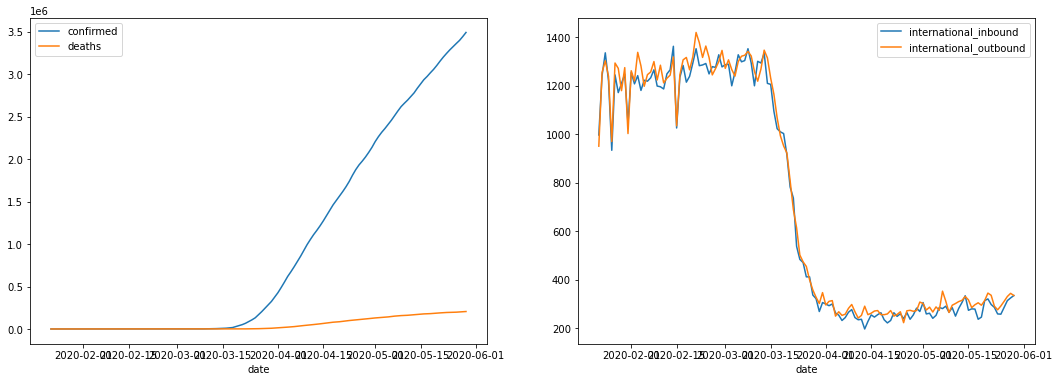

In [17]:
# we can plot the cumulative cases against air traffic of any country
import matplotlib.pyplot as plt
%matplotlib inline

us_data = df_air_traffic_covid.where(col('country')=='US').drop('recovered').toPandas()

fig, axes = plt.subplots(ncols=2, figsize=(18,6))
us_data.plot(x='date', y=['confirmed', 'deaths'], ax=axes[0])
us_data.plot(x='date', y=['international_inbound', 'international_outbound'], ax=axes[1])

We can see that after mid-March, the air traffic across the United States dropped steeply as COVID-19 infections started rising. This matches with our knowledge of events as internation travel was limited and lockdowns were imposed during the same period.

## Pipeline Design

### Tools
Apache Spark was used as the tool for creating this pipeline because complicated data manipulations and joins were needed to aggregate the data. The initial flight data was around 15 million records. Hence, Spark is a perfect fit for this dataset and model.

### Data updates
The data in the dataset is aggregated at daily intervals. Hence the lowest update frequency is daily.

**The data was increased by 100x**

If data volume is increase, our pipeline will still work since its cluster based and can be scaled up. The Spark cluster can be run on Amazon EMR and scaled up to add more compute instances.

**The data populates a dashboard that must be updated on a daily basis by 7am every day**

We can automate the pipeline by using Apache Airflow. We can create a data pipeline that first downloads newest dataset files from OpenSky and COVID-19 files from AWS COVID-19 data lake. Alternatively, we can read the COVID data directly from S3 within Spark. After reading the data, a Spark operator can execute a python version of the Spark work we defined in this notebook.

**The database needed to be accessed by 100+ people**

We can save the parquet files in HDFS to support the traffic. As a better alternative, we can save the data in Amazon Redshift. We can even save the data in a conventional SQL database since the aggregated data is not that huge.

### Credits
Matthias Schäfer, Martin Strohmeier, Vincent Lenders, Ivan Martinovic and Matthias Wilhelm.
"Bringing Up OpenSky: A Large-scale ADS-B Sensor Network for Research".
In Proceedings of the 13th IEEE/ACM International Symposium on Information Processing in Sensor Networks (IPSN), pages 83-94, April 2014.